## Notebook Contents and Objectives:
This notebook contains details of
- transformers package
- 'DonutFeatureExtractor', 'DonutProcessor'
- processor, processor.tokenizer behaviour
- VisionEncoderDecoderModel
- processor.tokenizer.convert_tokens_to_ids
- Decoder Input id creation and prompt creation
- decoder_input_ids
- huggingface datasets class and it's behaviour
- VisionEncoderDecoderConfig
- Explanation of decoder_input_ids and labels tensor
- explanation of add_tokens


## Important Resource:
- https://chatbotslife.com/information-extraction-with-donut-1a7267ab6993
- https://www.analyticsvidhya.com/blog/2023/03/revolutionizing-document-processing-through-docvqa/
- https://colab.research.google.com/drive/16iPnVD68oMnCqxHcLaq9qn9zkRaIGeab?usp=sharing#scrollTo=NimOFZS9FPqV
- https://www.philschmid.de/fine-tuning-donut
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Donut/DocVQA/Fine_tune_Donut_on_DocVQA.ipynb

In [ ]:
!pip install -q datasets
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00


In [ ]:
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing

In [ ]:
import numpy as np
import pandas as pd
import os
import json
from datasets import Dataset
import json
import inspect

from PIL import Image
import torch
print("CUDA available:", torch.cuda.is_available())
# from donut import DonutModel
from transformers import DonutProcessor, VisionEncoderDecoderModel

CUDA available: False


In [ ]:
train_path_main = '/content/drive/MyDrive/docVqa_dataset/train/train_v1.0.json'

In [ ]:
# Open the JSON file
with open(train_path_main, 'r') as file:
  # Load the contents of the file into a dictionary
  data_train = json.load(file)

## Convert 'data' list into dataframe by passing into the dataframe
df_train = pd.DataFrame(data_train['data'])

## Creating new dataframe having full image path

base_train_path = '/content/drive/MyDrive/docVqa_dataset/train'

# Define a function to join the base path with the image path
def join_paths(image_path):
    return os.path.join(base_train_path, image_path)

# Apply the function to create a new column with the full image path
df_train['full_path_image'] = df_train['image'].apply(join_paths)

## Making subset of the training dataframe
df_sub = df_train.iloc[:200]

print(df_sub.shape)
print(df_sub.head())

## Convert dataframe into dataset object
hfdataset_sub = Dataset.from_pandas(df_sub)

print(hfdataset_sub.shape)

print(len(hfdataset_sub))

print(hfdataset_sub.column_names)
print(hfdataset_sub[0])

(200, 9)
   questionId                                           question  \
0         337         what is the date mentioned in this letter?   
1         338  what is the contact person name mentioned in l...   
2         339            Which corporation's letterhead is this?   
3         340                      Who is in  cc in this letter?   
4         341               what is the subject of  this letter?   

                      image  docId ucsf_document_id ucsf_document_page_no  \
0  documents/xnbl0037_1.png    279         xnbl0037                     1   
1  documents/xnbl0037_1.png    279         xnbl0037                     1   
2  documents/mxcj0037_1.png    280         mxcj0037                     1   
3  documents/mxcj0037_1.png    280         mxcj0037                     1   
4  documents/mxcj0037_1.png    280         mxcj0037                     1   

                                        answers data_split  \
0                                      [1/8/93]      trai

### Digging details of donut and visionencoder decoder class from transformers module/package

## Details of transformers packackage:

In [ ]:
import transformers

In [ ]:
print(dir(transformers))

['ALBERT_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALBERT_PRETRAINED_MODEL_ARCHIVE_LIST', 'ALIGN_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALIGN_PRETRAINED_MODEL_ARCHIVE_LIST', 'ALL_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALTCLIP_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALTCLIP_PRETRAINED_MODEL_ARCHIVE_LIST', 'ASTConfig', 'ASTFeatureExtractor', 'ASTForAudioClassification', 'ASTModel', 'ASTPreTrainedModel', 'AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP', 'AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_MODEL_ARCHIVE_LIST', 'AUTOFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP', 'AUTOFORMER_PRETRAINED_MODEL_ARCHIVE_LIST', 'Adafactor', 'AdamW', 'AdamWeightDecay', 'AdaptiveEmbedding', 'AddedToken', 'Agent', 'AlbertConfig', 'AlbertForMaskedLM', 'AlbertForMultipleChoice', 'AlbertForPreTraining', 'AlbertForQuestionAnswering', 'AlbertForSequenceClassification', 'AlbertForTokenClassification', 'AlbertModel', 'AlbertPreTrainedModel', 'AlbertTokenizer', 'AlbertTokenizerFast', 'AlignConfig', 'AlignModel', 'AlignPreTrainedModel', 'Ali

## Note:
- 'transformers' module or package contains donut related class
      - 'DonutFeatureExtractor', 'DonutProcessor'
  - The DonutFeatureExtractor class is responsible for preprocessing the input image and [XLMRobertaTokenizer/XLMRobertaTokenizerFast] decodes the generated target tokens to the target string.
  - The DonutProcessor wraps DonutFeatureExtractor and [XLMRobertaTokenizer/XLMRobertaTokenizerFast] into a single instance to both extract the input features and decode the predicted token ids.
      - 'DonutImageProcessor':
      - 'DonutSwinConfig':
      - 'DonutSwinModel':
      - 'DonutSwinPreTrainedModel':
  - 'VisionEncoderDecoderConfig', 'VisionEncoderDecoderModel'  

In [ ]:
print(dir(transformers.DonutFeatureExtractor))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_get_files_timestamps', '_set_processor_class', '_upload_modified_files', 'align_long_axis', 'from_dict', 'from_json_file', 'from_pretrained', 'get_image_processor_dict', 'model_input_names', 'normalize', 'pad', 'pad_image', 'preprocess', 'push_to_hub', 'register_for_auto_class', 'rescale', 'resize', 'save_pretrained', 'thumbnail', 'to_dict', 'to_json_file', 'to_json_string']


In [ ]:
print(dir(transformers.DonutFeatureExtractor.from_pretrained))

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [ ]:
print(dir(transformers.DonutImageProcessor))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_get_files_timestamps', '_set_processor_class', '_upload_modified_files', 'align_long_axis', 'from_dict', 'from_json_file', 'from_pretrained', 'get_image_processor_dict', 'model_input_names', 'normalize', 'pad', 'pad_image', 'preprocess', 'push_to_hub', 'register_for_auto_class', 'rescale', 'resize', 'save_pretrained', 'thumbnail', 'to_dict', 'to_json_file', 'to_json_string']


In [ ]:
print(print(dir(transformers.DonutProcessor)))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_get_arguments_from_pretrained', '_get_files_timestamps', '_upload_modified_files', 'as_target_processor', 'attributes', 'batch_decode', 'decode', 'feature_extractor', 'feature_extractor_class', 'from_pretrained', 'image_processor_class', 'model_input_names', 'push_to_hub', 'register_for_auto_class', 'save_pretrained', 'token2json', 'tokenizer_class']
None


In [ ]:
print(dir(transformers.DonutSwinConfig))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_dict_from_json_file', '_get_config_dict', '_get_files_timestamps', '_set_token_in_kwargs', '_upload_modified_files', 'attribute_map', 'dict_torch_dtype_to_str', 'from_dict', 'from_json_file', 'from_pretrained', 'get_config_dict', 'is_composition', 'model_type', 'name_or_path', 'num_labels', 'push_to_hub', 'register_for_auto_class', 'save_pretrained', 'to_dict', 'to_diff_dict', 'to_json_file', 'to_json_string', 'update', 'update_from_string', 'use_return_dict']


In [ ]:
print(dir(transformers.DonutProcessor.from_pretrained))

['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


## Execution of DonutProcessor module and train donut-base:
- processor.tokenizer.convert_tokens_to_ids and add_tokens working principle

In [ ]:
model_checkpoint = "naver-clova-ix/donut-base"    ## base donut model

In [ ]:
processor = DonutProcessor.from_pretrained(model_checkpoint)
# processing raw data to the input format required for the Donut Model

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
len(processor.tokenizer)

57525

In [ ]:
additional_tokens = ["<s_answer>"]
print(processor.tokenizer.add_tokens(additional_tokens))
print(len(processor.tokenizer))

1
57526


In [ ]:
model_0 = VisionEncoderDecoderModel.from_pretrained(model_checkpoint)
model_0.decoder.resize_token_embeddings(len(processor.tokenizer))

Embedding(57526, 1024)

In [ ]:
print(processor.tokenizer.get_vocab()["<s_answer>"])

57525


In [ ]:
prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids("<s_answer>")
print(prompt_end_token_id)

57525


In [ ]:
processor.tokenizer.__class__.from_pretrained(processor.tokenizer.name_or_path)

XLMRobertaTokenizerFast(name_or_path='naver-clova-ix/donut-base', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s_iitcdip>', '<s_synthdog>']}, clean_up_tokenization_spaces=True)

## Details of 'processor' instance and how 'pixel_values' are returning its value

In [ ]:
type(processor)

transformers.models.donut.processing_donut.DonutProcessor

In [ ]:
print(processor)

DonutProcessor:
- image_processor: DonutImageProcessor {
  "do_align_long_axis": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "do_thumbnail": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DonutImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "DonutProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 2560,
    "width": 1920
  }
}

- tokenizer: XLMRobertaTokenizerFast(name_or_path='naver-clova-ix/donut-base', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s_iitcdip>', '<s_synthd

In [ ]:
print(dir(processor))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_get_arguments_from_pretrained', '_get_files_timestamps', '_in_target_context_manager', '_upload_modified_files', 'as_target_processor', 'attributes', 'batch_decode', 'current_processor', 'decode', 'feature_extractor', 'feature_extractor_class', 'from_pretrained', 'image_processor', 'image_processor_class', 'model_input_names', 'push_to_hub', 'register_for_auto_class', 'save_pretrained', 'token2json', 'tokenizer', 'tokenizer_class']


In [ ]:
## Checking the dictionary of attribute
print(vars(processor))

{'image_processor': DonutImageProcessor {
  "do_align_long_axis": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "do_thumbnail": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DonutImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "DonutProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 2560,
    "width": 1920
  }
}
, 'tokenizer': XLMRobertaTokenizerFast(name_or_path='naver-clova-ix/donut-base', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s_iitcdip>', '<s_synthdog>']}, clean_

In [ ]:
if hasattr(processor, 'pixel_values'):
    print(processor.pixel_values)

In [ ]:
help(processor)

Help on DonutProcessor in module transformers.models.donut.processing_donut object:

class DonutProcessor(transformers.processing_utils.ProcessorMixin)
 |  DonutProcessor(image_processor=None, tokenizer=None, **kwargs)
 |  
 |  Constructs a Donut processor which wraps a Donut image processor and an XLMRoBERTa tokenizer into a single
 |  processor.
 |  
 |  [`DonutProcessor`] offers all the functionalities of [`DonutImageProcessor`] and
 |  [`XLMRobertaTokenizer`/`XLMRobertaTokenizerFast`]. See the [`~DonutProcessor.__call__`] and
 |  [`~DonutProcessor.decode`] for more information.
 |  
 |  Args:
 |      image_processor ([`DonutImageProcessor`]):
 |          An instance of [`DonutImageProcessor`]. The image processor is a required input.
 |      tokenizer ([`XLMRobertaTokenizer`/`XLMRobertaTokenizerFast`]):
 |          An instance of [`XLMRobertaTokenizer`/`XLMRobertaTokenizerFast`]. The tokenizer is a required input.
 |  
 |  Method resolution order:
 |      DonutProcessor
 |      tra

In [ ]:
# Number of parameter acceptance in processor
params_pro = inspect.signature(processor).parameters
param_names_pro = [param for param in params_pro.keys()]

param_names_pro

['args', 'kwargs']

In [ ]:
call_sig = inspect.signature(processor.__call__)
print(call_sig)

(*args, **kwargs)


In [ ]:
# Get the source code of the __call__ method
source = inspect.getsource(processor.__call__)
print(source)

    def __call__(self, *args, **kwargs):
        """
        When used in normal mode, this method forwards all its arguments to AutoImageProcessor's
        [`~AutoImageProcessor.__call__`] and returns its output. If used in the context
        [`~DonutProcessor.as_target_processor`] this method forwards all its arguments to DonutTokenizer's
        [`~DonutTokenizer.__call__`]. Please refer to the doctsring of the above two methods for more information.
        """
        # For backward compatibility
        if self._in_target_context_manager:
            return self.current_processor(*args, **kwargs)

        images = kwargs.pop("images", None)
        text = kwargs.pop("text", None)
        if len(args) > 0:
            images = args[0]
            args = args[1:]

        if images is None and text is None:
            raise ValueError("You need to specify either an `images` or `text` input to process.")

        if images is not None:
            inputs = self.image_processor(im

In [ ]:
# image_path = "/content/drive/MyDrive/testImage/Bills.jpeg"
# image = Image.open(image_path)
# inputs = processor(image, return_tensors="pt")

In [ ]:
# type(inputs)

In [ ]:
# inputs

#### Note:
- BatchFeature class returned by processor(image, return_tensors="pt") is actually a dictionary-like object. It inherits from collections.OrderedDict and contains various keys with their corresponding values.
- BatchFeature is a custom class defined in the transformers.image_processing_utils module of the Hugging Face Transformers library. It is specifically designed to represent batches of image features as dictionary-like objects.

- In the BatchFeature class definition, you can see that it inherits from the Python collections.abc.Mapping class, which is an abstract base class that defines the interface for dictionary-like objects in Python. This means that BatchFeature is guaranteed to implement all the required methods of a dictionary-like object, including the keys() method, which is why you can call inputs.keys() on a BatchFeature object.

- You can also inspect the source code of the BatchFeature class to see how it is implemented and verify that it meets the requirements of a dictionary-like object.

In [ ]:
# inputs.keys()

In [ ]:
# pixel_values = inputs["pixel_values"]

# # Inspect the tensor
# print(pixel_values.shape)
# print(pixel_values.dtype)
# print(pixel_values)

## Accessing 'processor.tokenizer' module and researching its details lastly formed decoder_input_ids

In [ ]:
print(processor.tokenizer)

XLMRobertaTokenizerFast(name_or_path='naver-clova-ix/donut-base', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s_iitcdip>', '<s_synthdog>']}, clean_up_tokenization_spaces=True)


In [ ]:
print(dir(processor.tokenizer))

['SPECIAL_TOKENS_ATTRIBUTES', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_tokens', '_additional_special_tokens', '_auto_class', '_batch_encode_plus', '_bos_token', '_call_one', '_cls_token', '_convert_encoding', '_convert_id_to_token', '_convert_token_to_id_with_added_voc', '_create_repo', '_decode', '_decode_use_source_tokenizer', '_encode_plus', '_eos_token', '_eventual_warn_about_too_long_sequence', '_eventually_correct_t5_max_length', '_from_pretrained', '_get_files_timestamps', '_get_padding_truncation_strategies', '_in_target_context_manager', '_mask_token', '_pad', '_pad_token', '_pad_token_type_id', '_processor_class', '_save_pretrained

In [ ]:
processor.tokenizer.batch_decode

<bound method PreTrainedTokenizerBase.batch_decode of XLMRobertaTokenizerFast(name_or_path='naver-clova-ix/donut-base', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s_iitcdip>', '<s_synthdog>']}, clean_up_tokenization_spaces=True)>

In [ ]:
# Number of parameter acceptance in processor.tokenizer method
params_tok = inspect.signature(processor.tokenizer).parameters
param_names_tok = [param for param in params_tok.keys()]

param_names_tok

['text',
 'text_pair',
 'text_target',
 'text_pair_target',
 'add_special_tokens',
 'padding',
 'truncation',
 'max_length',
 'stride',
 'is_split_into_words',
 'pad_to_multiple_of',
 'return_tensors',
 'return_token_type_ids',
 'return_attention_mask',
 'return_overflowing_tokens',
 'return_special_tokens_mask',
 'return_offsets_mapping',
 'return_length',
 'verbose',
 'kwargs']

In [ ]:
# Checking the dictionary of attribute
vars(processor.tokenizer)

{'_tokenizer': <tokenizers.Tokenizer at 0x56f04d877a80>,
 '_decode_use_source_tokenizer': False,
 'init_inputs': (),
 'init_kwargs': {'bos_token': '<s>',
  'eos_token': '</s>',
  'sep_token': '</s>',
  'cls_token': '<s>',
  'unk_token': '<unk>',
  'pad_token': '<pad>',
  'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True),
  'name_or_path': 'naver-clova-ix/donut-base',
  'processor_class': 'DonutProcessor',
  'sp_model_kwargs': {},
  'special_tokens_map_file': None},
 'name_or_path': 'naver-clova-ix/donut-base',
 '_processor_class': 'DonutProcessor',
 'model_max_length': 1000000000000000019884624838656,
 'padding_side': 'right',
 'truncation_side': 'right',
 'model_input_names': ['input_ids', 'attention_mask'],
 'clean_up_tokenization_spaces': True,
 'deprecation_warnings': {},
 '_in_target_context_manager': False,
 '_bos_token': '<s>',
 '_eos_token': '</s>',
 '_unk_token': '<unk>',
 '_sep_token': '</s>',
 '_pad_token': '<pad>',
 '_cls_toke

In [ ]:
## To get docstirng and it's details of the list of parameters and return value
help(processor.tokenizer.batch_encode_plus)

Help on method batch_encode_plus in module transformers.tokenization_utils_base:

batch_encode_plus(batch_text_or_text_pairs: Union[List[str], List[Tuple[str, str]], List[List[str]], List[Tuple[List[str], List[str]]], List[List[int]], List[Tuple[List[int], List[int]]]], add_special_tokens: bool = True, padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False, truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None, max_length: Optional[int] = None, stride: int = 0, is_split_into_words: bool = False, pad_to_multiple_of: Optional[int] = None, return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None, return_token_type_ids: Optional[bool] = None, return_attention_mask: Optional[bool] = None, return_overflowing_tokens: bool = False, return_special_tokens_mask: bool = False, return_offsets_mapping: bool = False, return_length: bool = False, verbose: bool = True, **kwargs) -> transformers.tokenization_utils_ba

In [ ]:
help(processor.tokenizer.add_tokens)

Help on method add_tokens in module transformers.tokenization_utils_base:

add_tokens(new_tokens: Union[str, tokenizers.AddedToken, List[Union[str, tokenizers.AddedToken]]], special_tokens: bool = False) -> int method of transformers.models.xlm_roberta.tokenization_xlm_roberta_fast.XLMRobertaTokenizerFast instance
    Add a list of new tokens to the tokenizer class. If the new tokens are not in the vocabulary, they are added to
    it with indices starting from length of the current vocabulary and and will be isolated before the tokenization
    algorithm is applied. Added tokens and tokens from the vocabulary of the tokenization algorithm are therefore
    not treated in the same way.
    
    Note, when adding new tokens to the vocabulary, you should make sure to also resize the token embedding matrix
    of the model so that its embedding matrix matches the tokenizer.
    
    In order to do that, please use the [`~PreTrainedModel.resize_token_embeddings`] method.
    
    Args:
   

In [ ]:
print(processor.tokenizer.cls_token)
print(processor.tokenizer.eos_token)
print(processor.tokenizer.additional_special_tokens)

<s>
</s>
['<s_iitcdip>', '<s_synthdog>']


## Decoder Input id creation and prompt creation example

In [ ]:
# prepare decoder inputs
task_prompt = "<s_question>{user_input}</s_question><s_answer>J. T. WINEBRENNER</s_answer>"
print(task_prompt, type(task_prompt))

<s_question>{user_input}</s_question><s_answer>J. T. WINEBRENNER</s_answer> <class 'str'>


In [ ]:
question = "What is the name of the person in the field?"
print(question, type(question))

What is the name of the person in the field? <class 'str'>


In [ ]:
prompt = task_prompt.replace("{user_input}", question)
print(prompt, type(prompt))

<s_question>What is the name of the person in the field?</s_question><s_answer>J. T. WINEBRENNER</s_answer> <class 'str'>


In [ ]:
pro_tok = processor.tokenizer(prompt)
print(pro_tok)

{'input_ids': [0, 41040, 46192, 41403, 49706, 8888, 34791, 43703, 52743, 48941, 55856, 2587, 48941, 37517, 25515, 48941, 41095, 36209, 40598, 46192, 41403, 49706, 8888, 34791, 57525, 52744, 39539, 38946, 39539, 46193, 34067, 45202, 36234, 43922, 40598, 46192, 41403, 355, 47680, 34791, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
type(pro_tok), pro_tok.keys()

(transformers.tokenization_utils_base.BatchEncoding,
 dict_keys(['input_ids', 'attention_mask']))

In [ ]:
## list return
decoder_input_ids = processor.tokenizer(prompt,max_length=100,padding="max_length").input_ids
print(decoder_input_ids)
print(processor.decode(decoder_input_ids))

[0, 41040, 46192, 41403, 49706, 8888, 34791, 43703, 52743, 48941, 55856, 2587, 48941, 37517, 25515, 48941, 41095, 36209, 40598, 46192, 41403, 49706, 8888, 34791, 57525, 52744, 39539, 38946, 39539, 46193, 34067, 45202, 36234, 43922, 40598, 46192, 41403, 355, 47680, 34791, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s> <s_question>What is the name of the person in the field?</s_question><s_answer> J. T. WINEBRENNER</s_answer></s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
## tensor return
decoder_input_ids_ten = processor.tokenizer(prompt, return_tensors="pt",max_length=100,padding="max_length").input_ids.squeeze(0)
print(decoder_input_ids_ten)

tensor([    0, 41040, 46192, 41403, 49706,  8888, 34791, 43703, 52743, 48941,
        55856,  2587, 48941, 37517, 25515, 48941, 41095, 36209, 40598, 46192,
        41403, 49706,  8888, 34791, 57525, 52744, 39539, 38946, 39539, 46193,
        34067, 45202, 36234, 43922, 40598, 46192, 41403,   355, 47680, 34791,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])


In [ ]:
## Tensor Clone for label
decoder_input_ids_ten_clone = decoder_input_ids_ten.clone()
print(decoder_input_ids_ten_clone)

tensor([    0, 41040, 46192, 41403, 49706,  8888, 34791, 43703, 52743, 48941,
        55856,  2587, 48941, 37517, 25515, 48941, 41095, 36209, 40598, 46192,
        41403, 49706,  8888, 34791, 57525, 52744, 39539, 38946, 39539, 46193,
        34067, 45202, 36234, 43922, 40598, 46192, 41403,   355, 47680, 34791,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])


In [ ]:
print(processor.tokenizer.pad_token)
print(processor.tokenizer.pad_token_id)

<pad>
1


In [ ]:
ignore_id = -100
decoder_input_ids_ten_clone[decoder_input_ids_ten_clone == processor.tokenizer.pad_token_id] = ignore_id
print(decoder_input_ids_ten_clone)
print('***********************************************************************')
decoder_input_ids_ten_clone[ : torch.nonzero(decoder_input_ids_ten_clone == torch.tensor(prompt_end_token_id)).sum() + 1] = ignore_id
print(decoder_input_ids_ten_clone)

tensor([    0, 41040, 46192, 41403, 49706,  8888, 34791, 43703, 52743, 48941,
        55856,  2587, 48941, 37517, 25515, 48941, 41095, 36209, 40598, 46192,
        41403, 49706,  8888, 34791, 57525, 52744, 39539, 38946, 39539, 46193,
        34067, 45202, 36234, 43922, 40598, 46192, 41403,   355, 47680, 34791,
            2,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])
***********************************************************************
tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100

## Detail experiment of huggingface datasets class

In [ ]:
import datasets

In [ ]:
print(dir(datasets))

['Array2D', 'Array3D', 'Array4D', 'Array5D', 'ArrowBasedBuilder', 'Audio', 'AudioClassification', 'AutomaticSpeechRecognition', 'BeamBasedBuilder', 'BuilderConfig', 'ClassLabel', 'Dataset', 'DatasetBuilder', 'DatasetDict', 'DatasetInfo', 'DownloadConfig', 'DownloadManager', 'DownloadMode', 'Features', 'GeneratorBasedBuilder', 'Image', 'ImageClassification', 'IterableDataset', 'IterableDatasetDict', 'LanguageModeling', 'Metric', 'MetricInfo', 'NamedSplit', 'NamedSplitAll', 'QuestionAnsweringExtractive', 'ReadInstruction', 'Sequence', 'Split', 'SplitBase', 'SplitDict', 'SplitGenerator', 'SplitInfo', 'StreamingDownloadManager', 'SubSplitInfo', 'Summarization', 'TaskTemplate', 'TextClassification', 'Translation', 'TranslationVariableLanguages', 'Value', 'VerificationMode', 'Version', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'arrow_dataset', 'arrow_reader', 'arrow_writer', 'builder', 'combine', 'conc

In [ ]:
print(dir(datasets.Dataset))

['_TF_DATASET_REFS', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getitems__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_local_temp_path', '_check_index_is_initialized', '_estimate_nbytes', '_generate_tables_from_cache_file', '_generate_tables_from_shards', '_get_cache_file_path', '_get_output_signature', '_getitem', '_map_single', '_new_dataset_with_indices', '_push_parquet_shards_to_hub', '_save_to_disk_single', '_select_contiguous', '_select_with_indices_mapping', 'add_column', 'add_elasticsearch_index', 'add_faiss_index', 'add_faiss_index_from_external_arrays', 'add_item', 'align_labels_with_mapping', 'builder_name', 'cache_files', 'cast', 'cast_

#### Note: 'Dataset'
- Dataset is a class that represents a dataset object in the Hugging Face library. It contains the data and associated metadata, such as the dataset name, size, feature names, and description

In [ ]:
hfdataset_sub

Dataset({
    features: ['questionId', 'question', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers', 'data_split', 'full_path_image'],
    num_rows: 200
})

In [ ]:
print(dir(datasets.load_dataset))

['__annotations__', '__builtins__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


#### Note: 'load_dataset'
- A utility function is a small, specialized function that is designed to perform a specific task or solve a particular problem
- Utility functions are often created to simplify code and make it more readable, maintainable, and reusable
- 'load_dataset' is a utility function that allows you to download and load a pre-built dataset from the Hugging Face library.
- *** It returns a DatasetDict object that contains one or more Dataset objects representing the training, validation, and test splits of the dataset, along with other metadata.

### Q. Difference between HF 'Dataset' and 'load_dataset' also when to use which?
- Ans_1 : Main difference between 'datasets.Dataset' and 'datasets.load_dataset' is that 'datasets.Dataset' is used to create a dataset object from a custom data source, while 'datasets.load_dataset' is used to load a pre-built dataset from the Hugging Face library
- Ans_2 : You should use datasets.Dataset when you have your own data and want to create a Dataset object to work with in the Hugging Face library. On the other hand, you should use datasets.load_dataset when you want to use a pre-built dataset from the Hugging Face library for your NLP task. This allows you to save time and avoid the hassle of manually downloading and preprocessing the data yourself.

In [ ]:
type(hfdataset_sub)

datasets.arrow_dataset.Dataset

In [ ]:
hfdataset_sub.features

{'questionId': Value(dtype='int64', id=None),
 'question': Value(dtype='string', id=None),
 'image': Value(dtype='string', id=None),
 'docId': Value(dtype='int64', id=None),
 'ucsf_document_id': Value(dtype='string', id=None),
 'ucsf_document_page_no': Value(dtype='string', id=None),
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'data_split': Value(dtype='string', id=None),
 'full_path_image': Value(dtype='string', id=None)}

In [ ]:
hfdataset_sub.num_rows

200

In [ ]:
example = hfdataset_sub[0]
example

{'questionId': 337,
 'question': 'what is the date mentioned in this letter?',
 'image': 'documents/xnbl0037_1.png',
 'docId': 279,
 'ucsf_document_id': 'xnbl0037',
 'ucsf_document_page_no': '1',
 'answers': ['1/8/93'],
 'data_split': 'train',
 'full_path_image': '/content/drive/MyDrive/docVqa_dataset/train/documents/xnbl0037_1.png'}

In [ ]:
type(example)

dict

In [ ]:
example.keys()

dict_keys(['questionId', 'question', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers', 'data_split', 'full_path_image'])

In [ ]:
sample_image_path = example['full_path_image']
sample_image_path

'/content/drive/MyDrive/docVqa_dataset/train/documents/xnbl0037_1.png'

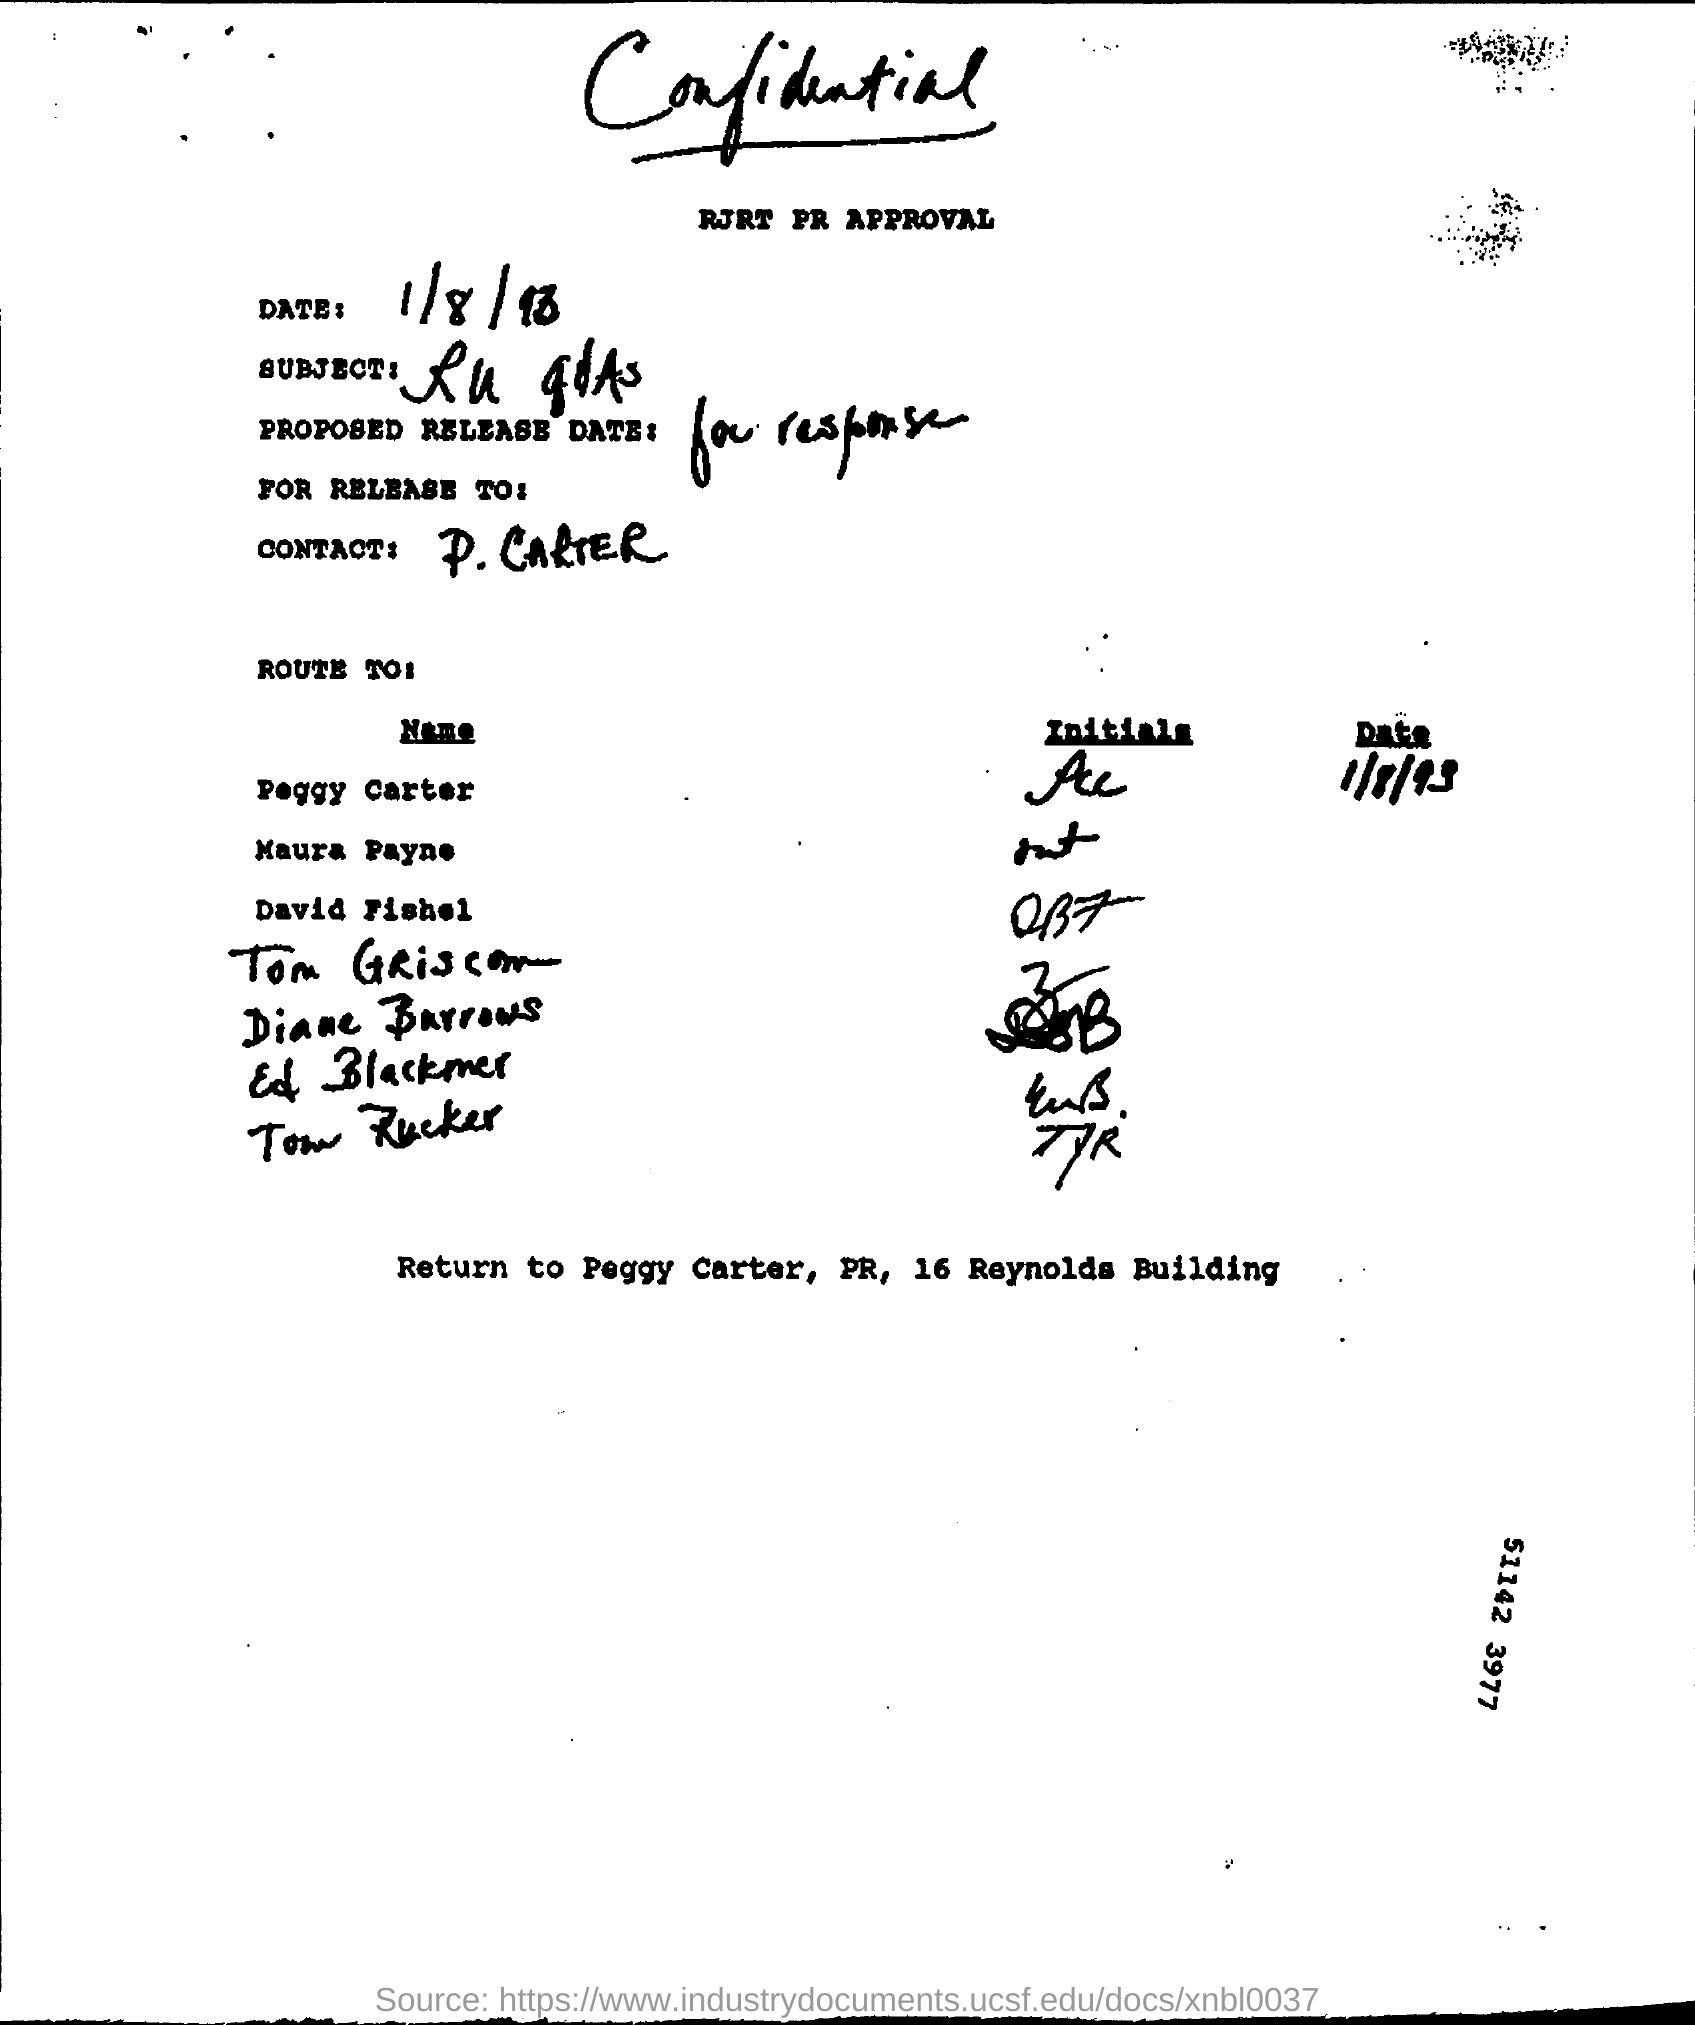

In [ ]:
## viewing sample example image from hfdataset object
sam_image = Image.open(sample_image_path)
sam_image

In [ ]:
type(sam_image)

PIL.PngImagePlugin.PngImageFile

In [ ]:
# Convert the PIL image to a NumPy array
sam_np_array = np.array(sam_image)

# Print the shape of the NumPy array
print(sam_np_array.shape)

(2025, 1695)


In [ ]:
## Corresponding Question in this sample example
example['question']

'what is the date mentioned in this letter?'

In [ ]:
## Corresponding Answer in this sample example
example['answers']

['1/8/93']

### Add ground_truth for Donut:
Donut requires you to add a column with some ground truth JSON/txt/JSON lines/whatever that you'd like the model to learn to generate. Below, we define a function that we'll apply on the entire dataset to add this column.

In [ ]:
import re

In [ ]:
# images = sample_image
sam_question = example['question']
sam_answers = example['answers']

In [ ]:
sam_ground_truths = []

In [ ]:
sam_question = sam_question.replace('\\"', "")
sam_question = re.sub(' +', ' ', sam_question)
sam_question = sam_question.replace('"', '\"')

In [ ]:
sam_question, type(sam_question)

('what is the date mentioned in this letter?', str)

In [ ]:
sam_answers, len(sam_answers)

(['1/8/93'], 1)

In [ ]:
sam_ground_truth_example = '{"gt_parses": ['
sam_ground_truth_example, type(sam_ground_truth_example)

('{"gt_parses": [', str)

In [ ]:
for idx, answer in enumerate(sam_answers):
  print(f"Respective Index and Answer is : {idx} : {answer}")
  ans = answer.replace('"', '\"')
  print(f'Answer is : {ans}')
  sam_ground_truth_example += '{"question" : "' + sam_question + '", "answer" : "' + ans + '"}'
  print(sam_ground_truth_example)
  print('---------*****-------------')
sam_ground_truth_example += ']}'
print(sam_ground_truth_example)
print('----------------------')
sam_ground_truths.append(sam_ground_truth_example)
print(sam_ground_truths)

Respective Index and Answer is : 0 : 1/8/93
Answer is : 1/8/93
{"gt_parses": [{"question" : "what is the date mentioned in this letter?", "answer" : "1/8/93"}
---------*****-------------
{"gt_parses": [{"question" : "what is the date mentioned in this letter?", "answer" : "1/8/93"}]}
----------------------
['{"gt_parses": [{"question" : "what is the date mentioned in this letter?", "answer" : "1/8/93"}]}']


## Preparing gt_parse for whole dataset

In [ ]:
# Creating custom function for DOCVQA task
def add_ground_truth(hf_examples):
  images = hf_examples['full_path_image']
  questions = hf_examples['question']
  answers = hf_examples['answers']

  ground_truths = []    # Creating empty list
  for image,question, answer in zip(images,questions, answers):
    # we need to escape " characters appearing in the query and/or answer
    question = question.replace("\\", "") ## this was just one corrupt example (index 91 of training set)
    question = re.sub(' +', ' ', question)
    question = question.replace('"', '\\"')   # replacement of " from question
    # let's create the ground truth string
    ground_truth_example = '{"gt_parses": ['
    for idx, answ in enumerate(answer):
      # ans = answ.replace('"', '\"')   # replacement of " from answer
      answ = answ.replace("\\", "")
      ans = answ.replace('"', '\\"')
      ground_truth_example += '{"question" : "' + question + '", "answer" : "' + ans + '"}'

      # add comma for more than one element present in the answer list
      if idx != len(answer) - 1:   # when current index is not equal to last index
        ground_truth_example += ', '
    ground_truth_example += ']}'
    ground_truths.append(ground_truth_example)    ## appending ground_truths list for every row

  hf_examples['ground_truth'] = ground_truths

  return hf_examples

In [ ]:
hfdataset_sub_gt = hfdataset_sub.map(add_ground_truth, batched=True)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
hfdataset_sub_gt

Dataset({
    features: ['questionId', 'question', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers', 'data_split', 'full_path_image', 'ground_truth'],
    num_rows: 200
})

### Checking whether GT_Parse working fine or not.
- Checking the whole with three example

In [ ]:
def gtCheck(indx):    # Put the index value

  example_indx = hfdataset_sub_gt[indx]
  example_indx_gt_dict = json.loads(example_indx['ground_truth'])
  return example_indx_gt_dict

In [ ]:
df_sub.iloc[135]['answers']

['Atlanta, georgia', 'Atlanta, Georgia']

In [ ]:
## sample example 135
example_135_gt_dict = gtCheck(135)
example_135_gt_dict

{'gt_parses': [{'question': 'Where is One Coca-Cola Plaza located?',
   'answer': 'Atlanta, georgia'},
  {'question': 'Where is One Coca-Cola Plaza located?',
   'answer': 'Atlanta, Georgia'}]}

In [ ]:
example_135 = hfdataset_sub_gt[135]
example_135
example_135['ground_truth']
type(example_135['ground_truth'])

example_135_gt_dict = json.loads(example_135['ground_truth'])   ## Convert it from str to json dict
example_135_gt_dict

example_135_gt_dict

{'gt_parses': [{'question': 'Where is One Coca-Cola Plaza located?',
   'answer': 'Atlanta, georgia'},
  {'question': 'Where is One Coca-Cola Plaza located?',
   'answer': 'Atlanta, Georgia'}]}

In [ ]:
# sample example 10
example_10_gt_dict = gtCheck(10)
example_10_gt_dict

{'gt_parses': [{'question': 'Which part of Virginia is this letter sent from',
   'answer': 'Richmond'}]}

In [ ]:
# sample example 100
example_100_gt_dict = gtCheck(100)
example_100_gt_dict

{'gt_parses': [{'question': 'To whom is this letter addressed?',
   'answer': 'R.Ferguson'}]}

## Execution and finding details of VisionEncoderDecoder Model and config

In [ ]:
from transformers import VisionEncoderDecoderConfig, VisionEncoderDecoderModel, BartConfig

In [ ]:
print(dir(transformers))

['ALBERT_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALBERT_PRETRAINED_MODEL_ARCHIVE_LIST', 'ALIGN_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALIGN_PRETRAINED_MODEL_ARCHIVE_LIST', 'ALL_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALTCLIP_PRETRAINED_CONFIG_ARCHIVE_MAP', 'ALTCLIP_PRETRAINED_MODEL_ARCHIVE_LIST', 'ASTConfig', 'ASTFeatureExtractor', 'ASTForAudioClassification', 'ASTModel', 'ASTPreTrainedModel', 'AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP', 'AUDIO_SPECTROGRAM_TRANSFORMER_PRETRAINED_MODEL_ARCHIVE_LIST', 'AUTOFORMER_PRETRAINED_CONFIG_ARCHIVE_MAP', 'AUTOFORMER_PRETRAINED_MODEL_ARCHIVE_LIST', 'Adafactor', 'AdamW', 'AdamWeightDecay', 'AdaptiveEmbedding', 'AddedToken', 'Agent', 'AlbertConfig', 'AlbertForMaskedLM', 'AlbertForMultipleChoice', 'AlbertForPreTraining', 'AlbertForQuestionAnswering', 'AlbertForSequenceClassification', 'AlbertForTokenClassification', 'AlbertModel', 'AlbertPreTrainedModel', 'AlbertTokenizer', 'AlbertTokenizerFast', 'AlignConfig', 'AlignModel', 'AlignPreTrainedModel', 'Ali

In [ ]:
VisionEncoderDecoderConfig

transformers.models.vision_encoder_decoder.configuration_vision_encoder_decoder.VisionEncoderDecoderConfig

In [ ]:
print(dir(VisionEncoderDecoderConfig))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_dict_from_json_file', '_get_config_dict', '_get_files_timestamps', '_set_token_in_kwargs', '_upload_modified_files', 'attribute_map', 'dict_torch_dtype_to_str', 'from_dict', 'from_encoder_decoder_configs', 'from_json_file', 'from_pretrained', 'get_config_dict', 'is_composition', 'model_type', 'name_or_path', 'num_labels', 'push_to_hub', 'register_for_auto_class', 'save_pretrained', 'to_dict', 'to_diff_dict', 'to_json_file', 'to_json_string', 'update', 'update_from_string', 'use_return_dict']


In [ ]:
# Number of parameter acceptance in VEDC
params_vedc = inspect.signature(VisionEncoderDecoderConfig).parameters
param_names_vedc = [param for param in params_vedc.keys()]

param_names_vedc

['kwargs']

In [ ]:
print(dir(VisionEncoderDecoderModel))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_auto_class', '_backward_compatibility_gradient_checkpointing', '_call_impl', '_convert_head_mask_to_5d', '_create_repo', '_expand_inputs_for_generation', '_extract_past_from_model_output', '_from_config', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_decoder_start_token_id', '_get_files_timestamps', '_get_logits_processor', '_get_logits_warper', '_get_name', '_get_resized_embeddings', '_get_resized_lm_head', '_get_stopping_criteria', '_hook_rss_memory_post_forward', '_hook_rss_memory_pre_forward', '_init_weights', '_initialize_weights', '_keep_in_f

In [ ]:
VisionEncoderDecoderModel

transformers.models.vision_encoder_decoder.modeling_vision_encoder_decoder.VisionEncoderDecoderModel

In [ ]:
params_vedm = inspect.signature(VisionEncoderDecoderModel).parameters
param_names_vedm = [param for param in params_vedm.keys()]

param_names_vedm

['config', 'encoder', 'decoder']

### Note: Difference between VisionEncoderDecoderConfig and VisionEncoderDecoderModel:
- VisionEncoderDecoderConfig and VisionEncoderDecoderModel are two classes from the transformers library that are used for computer vision tasks, specifically for image captioning and object detection.

- VisionEncoderDecoderConfig is a configuration class that defines the hyperparameters for a VisionEncoderDecoderModel. It contains attributes such as the number of layers, hidden size, attention heads, dropout rate, and activation function. You can use this class to define a specific configuration for your VisionEncoderDecoderModel.

- VisionEncoderDecoderModel is a PyTorch module that implements an encoder-decoder architecture for image captioning and object detection. It consists of two main components: an image encoder and a text decoder. The image encoder is a pre-trained convolutional neural network that extracts image features, while the text decoder is a transformer that generates a sequence of tokens based on the input image features.

- In summary, VisionEncoderDecoderConfig is a configuration class that defines the hyperparameters for a VisionEncoderDecoderModel, while VisionEncoderDecoderModel is a PyTorch module that implements an encoder-decoder architecture for computer vision tasks.

### What is Configuaration class and files:
In the context of machine learning models, a configuration class is a Python class that contains a set of hyperparameters or settings that define how a model should behave during training and inference. A configuration class typically includes parameters such as learning rate, number of epochs, optimizer, activation function, etc.

A config file is a file that stores the values of these hyperparameters in a specific format, such as YAML, JSON or INI. Config files are used to easily customize the behavior of a model without changing its code. They allow users to experiment with different hyperparameters, compare different configurations, and reproduce experimental results.

The need for configuration classes and files is driven by the fact that machine learning models often have many hyperparameters that need to be tuned in order to obtain good performance. Manually changing these hyperparameters in code can be time-consuming, error-prone, and require recompiling the model. Config files provide an efficient way to change the hyperparameters without modifying the code, which makes it easier to experiment with different configurations and evaluate their performance.

Additionally, configuration files enable the reuse of the same model architecture with different sets of hyperparameters. For example, you can train the same model architecture for a specific task with different learning rates, optimizer, and batch sizes by using different configuration files. This saves time and reduces code duplication.

In summary, configuration classes and files are used to store the hyperparameters and settings of a machine learning model, allowing users to customize its behavior without modifying the code. They make it easier to experiment with different hyperparameters, compare different configurations, and reproduce experimental results.

### Q: When to use configuaration class and config file also at which situation?
A configuration class and a config file are separate concepts, although they are often used together in machine learning frameworks and libraries.

A configuration class defines a set of hyperparameters or settings that determine the behavior of a machine learning model during training and inference. It is usually defined as a Python class and can be used to create instances of a model with specific hyperparameters.

A config file, on the other hand, is a file that stores the hyperparameters and settings for a machine learning model in a specific format such as YAML, JSON or INI. It can be used to load the hyperparameters and settings into a model and change its behavior without modifying the code.

The choice of whether to use a configuration class or a config file depends on the requirements of the machine learning project and the framework being used. In some cases, a configuration class may be more suitable when the hyperparameters are specific to the implementation of a particular model or architecture. In other cases, a config file may be more flexible when the hyperparameters need to be changed often or when they are shared across different models or architectures.

In general, configuration classes are more tightly coupled with the implementation of a particular model or architecture, while config files are more loosely coupled and provide more flexibility to customize the hyperparameters and settings of a machine learning model.

#### Comment:
- 'max_length' refers to the maximum length of the generated text, which is an important hyperparameter in text generation tasks. It specifies the maximum number of tokens that the decoder can generate for each input image. In the example you provided, max_length is set to 128, which means that the decoder can generate a text with a maximum length of 128 tokens.
- 'image_size' refers to the size of the input image, which is an important parameter in vision tasks. It specifies the height and width of the input image in pixels. In the example you provided, image_size is set to [1280, 960], which means that the input image has a height of 1280 pixels and a width of 960 pixels.

## Creating config object and modify hyperparameter 'image_size' from encoder and 'max_length' from decoder keys

In [ ]:
config = VisionEncoderDecoderConfig.from_pretrained(model_checkpoint)

In [ ]:
type(config)

transformers.models.vision_encoder_decoder.configuration_vision_encoder_decoder.VisionEncoderDecoderConfig

In [ ]:
print(config)

VisionEncoderDecoderConfig {
  "_commit_hash": "a959cf33c20e09215873e338299c900f57047c61",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "add_final_layer_norm": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": null,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 4,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_attention_heads": 16,
    "encoder_ffn_dim": 4096,
    "encoder_layerdrop": 0.0,
    "encoder_layers": 12,
    "encoder_no_repeat_ngram_si

In [ ]:
## To see list of keys
keys = dir(config)
print(keys)

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_commit_hash', '_create_repo', '_dict_from_json_file', '_get_config_dict', '_get_files_timestamps', '_name_or_path', '_set_token_in_kwargs', '_upload_modified_files', 'add_cross_attention', 'architectures', 'attribute_map', 'bad_words_ids', 'begin_suppress_tokens', 'bos_token_id', 'chunk_size_feed_forward', 'cross_attention_hidden_size', 'decoder', 'decoder_start_token_id', 'dict_torch_dtype_to_str', 'diversity_penalty', 'do_sample', 'early_stopping', 'encoder', 'encoder_no_repeat_ngram_size', 'eos_token_id', 'exponential_decay_length_penalty', 'finetuning_task', 'forced_bos_token_id', 'forced_eos_token_id', 'fro

Comm: From here we want to access encoder and decoder keys and wqant to modify it

In [ ]:
# dynamically access the default values of the keys

# Way- 1
print(getattr(config.encoder, "image_size"))
print(getattr(config.decoder, "max_length"))

print('************************************************')
# Way- 2
print(config.encoder.image_size)
print(config.decoder.max_length)

[2560, 1920]
20
************************************************
[2560, 1920]
20


In [ ]:
## Set up max_length and image_size for our task
max_length = 128        # maximum length of the generated text / tokens that the decoder can generate for each input image
image_size = [1280, 960]    # size of the input image. It specifies the height and width of the input image in pixels

### Updating cofig value

In [ ]:
## Updating the configuration of a pre-trained VisionEncoderDecoderConfig instance

config.encoder.image_size  = image_size    # (height, width)
config.decoder.max_length  = max_length  # update max_length of the decoder (for generation of text)

In [ ]:
## Checking new and updating value
print(config.encoder.image_size)
print(config.decoder.max_length)

[1280, 960]
128


## Vision Encoder and Decoder Model Initialization


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint, config=config)

In [ ]:
model.config == config    ## both are same

True

In [ ]:
model.config.decoder_start_token_id

### Add special tokens


In [ ]:
from typing import List

In [ ]:
len(processor.tokenizer)

57526

In [ ]:
l = ['abc', 'xyz']
print(l)
nwl = processor.tokenizer.add_tokens(l)
print(nwl)

['abc', 'xyz']
2


In [ ]:
l1 = ['', '']
print(l1)
nwl1 = processor.tokenizer.add_tokens(l1)
print(nwl1)

['', '']
0


### Note: add_tokens: Empty strings
- 'add_tokens' method returns the number of newly added tokens, which is stored in the newly added variable (nwl or nwl1)
- add_tokens method only adds new tokens to the tokenizer's vocabulary if the tokens are not already present in the vocabulary. Since an empty string ("") is already a valid token in the tokenizer's vocabulary, passing it to the add_tokens method does not actually add any new tokens to the vocabulary.

- So even though the list ["", ""] is passed as an argument to the add_tokens method, the method does not actually add any new tokens to the tokenizer's vocabulary, as both empty strings are already valid tokens.
- Since the pre-trained tokenizer already has a large vocabulary, it is possible that the new tokens you added are already in the vocabulary. In that case, the add_tokens method will not add any new tokens to the vocabulary and will return 0.

- In your case, the add_tokens method returned 0 because it did not add any new tokens to the vocabulary. This could be because the tokens 'abc' and 'xyz' are already present in the pre-trained tokenizer's vocabulary.

#### Q: Why empty strings is not considered as a token in add_token from tokenizer?
Empty strings ("") are not considered as new tokens because they do not add any additional information to the existing tokens. Empty strings are essentially the absence of any characters, so adding them as new tokens would not provide any new information for the model to learn from.

Moreover, empty strings are not valid tokens because they do not have any meaning or semantic value in natural language. Therefore, they cannot be used to represent any information in the text.

When adding tokens to a tokenizer, each token should represent a distinct concept or entity that appears in the text. Adding empty strings as tokens would not serve any useful purpose and would only increase the size of the token vocabulary unnecessarily.

In [ ]:
def add_tokens(list_of_tokens: List[str]):
  '''
  Add tokens to the tokenizer and resize the token embeddings
  newly_added_num -> add_tokens method returns the number of newly added tokens, which is stored in the newly_added_num
  resize_token_embeddings -> the size of the token embeddings in the model's decoder is resized to match the new size of the tokenizer
  model.decoder.resize_token_embeddings() method, which takes the length of the tokenizer as input
  '''
  newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)   # returns number of newly added tokens

  if newly_added_num > 0:   # if neewly added number is greater than 0 then token embedding inside model decoder will be resized
    model.decoder.resize_position_embeddings(len(processor.tokenizer))

In [ ]:
additional_tokens = ["<yes/>", "<no/>"]

### Note: Objective of Donut Model: Explanation of decoder_input_ids and labels tensor
- Obj: Donut model, the goal is to generate a textual answer to a visual question. The model takes in an image and a prompt, which consists of a question and an optional answer. The input is processed by the encoder, which generates a fixed-length vector representation of the image and the prompt. This representation is then fed into the decoder to generate the output sequence, which is the textual answer.
- The image would be encoded into a feature vector using the vision encoder, and this feature vector would be used as the input to the language decoder. The language decoder would then generate the answer text token by token, using a masked language modeling objective.

- 'decoder_input_ids' tensor is an important component of the decoding process. It represents the input tokens that are fed into the decoder to generate the next set of tokens. The decoder_input_ids tensor is constructed from the previous set of generated tokens and is used to provide context to the decoder during the generation process.
- In the case of question answering, the prompt consists of both the question and the answer. The goal of the model is to generate the answer given the question and the image. However, we don't want the model to simply memorize the answer and regurgitate (to repeat information without understanding it) it during training. Instead, we want the model to learn how to generate the answer from the question and the image.
- The decoder_input_ids tensor represents the input to the language decoder. It consists of the special [CLS] token followed by the token IDs for the answer text. During training, the language decoder would use this input to generate the answer text one token at a time, using a masked language modeling objective.
- 'labels' tensor we created earlier, we set the tokens for the question to -100, which tells the model to ignore these tokens during training. The labels tensor is used as the target during training to compute the loss and update the model parameters.
- The decoder_input_ids tensor represents the input to the language decoder. The 'decoder_input_ids' tensor only contains the token IDs for the answer portion of the prompt, and does not include the question portion.
- To summarize, during training in the Donut vision encoder-decoder model, only the answer portion of the prompt is used as the target for the model to predict, and the question portion is ignored. The decoder_input_ids tensor only contains the token IDs for the answer portion of the prompt. The model is trained using cross-entropy loss to predict the correct token IDs for the answer portion of the prompt, given the encoded image and the decoder input IDs.
- During training, the model generates text only based on the decoder_input_ids tensor, which contains the token IDs for the answer portion of the prompt. The model is trained to generate the correct sequence of tokens for the answer based on the encoded image and the decoder_input_ids. The question portion of the prompt is ignored during training, and the model does not generate any text based on it.

  - ** Q: During training as there is no role of question part inside the whole prompt then why we includes always both question and answer part inside the prompt structure?
    - Including the question portion of the prompt along with the answer portion serves as a kind of "context" for the model during training. Even though the model is only trained to generate the answer portion of the prompt, having the question portion as part of the input helps the model understand the context in which the answer is being given. This can improve the model's ability to generate relevant and accurate answers.
    - In addition, including the question portion in the prompt allows for the possibility of using the same pre-trained model to generate answers to new questions that were not seen during training. By providing the model with the full prompt, which includes both the question and answer portions, the model can better understand the context of the question being asked and generate more accurate answers.
  - ** Q: Role of 'labels' parameter?
    - The role of the labels parameter is to specify which tokens in the decoder_input_ids tensor should be used as targets for the model during training. In particular, the labels tensor contains the same token sequence as the decoder_input_ids tensor, but with some tokens replaced by a special padding token (-100 in this case). Specifically, the tokens in the labels tensor that correspond to the question portion of the prompt are replaced by -100, indicating that these tokens should be ignored during training.

    - So by specifying the labels tensor in this way, we are essentially telling the model to focus on generating the answer portion of the prompt and to ignore the question portion.